In [20]:
# TODO: read about feature selection / combination in pipelines
# http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# http://scikit-learn.org/stable/auto_examples/feature_stacker.html
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html

# https://github.com/paulgb/sklearn-pandas

In [66]:
# global settings
CORES = -1        # parallelization
RND = 123        # random seed

In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import pipeline
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import tree
from sklearn import cross_validation
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

#### Data Load

In [35]:
def fetch(fname,
          drop=['PassengerId', 'Name', 'Ticket', 'Cabin'],
          add_derived=True):
    """
    add_title   : extract title (e.g., Mr, Ms, Mrs, etc) from passanger name
    """
    drop = drop or []
    df = pd.read_csv(fname)
    # optional: extract title from name
    if add_derived and 'Name' in df.columns:
        df['Title'] = (df['Name']
                       .apply(lambda x: x.split(',')[1].split()[0] if ',' in x else np.Nan)
                       .apply(lambda x: x[:-1] if x.endswith('.') else x))
    if add_derived and 'Cabin' in df.columns:
        df['Deck'] = df['Cabin'].str[:1].fillna('X')
    if add_derived and 'Ticket' in df.columns:
        df['TicketNum'] = df.Ticket.str.isnumeric().astype(np.float64)
    df_train.Ticket.str.isnumeric()
    drop = [col for col in drop if col in df.columns]
    df = df.drop(drop, axis=1)
    return df

In [36]:
# data
df = df_train = fetch('titanic/train.csv', drop=None)
df_comp  = fetch('titanic/test.csv', drop=None)
df.drop('Name', axis=1).head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,TicketNum
0,1,0,3,male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,X,0
1,2,1,1,female,38,1,0,PC 17599,71.2833,C85,C,Mrs,C,0
2,3,1,3,female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,X,0
3,4,1,1,female,35,1,0,113803,53.1000,C123,S,Mrs,C,1
4,5,0,3,male,35,0,0,373450,8.0500,NaN,S,Mr,X,1


#### Visualization

/Users/Anton/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


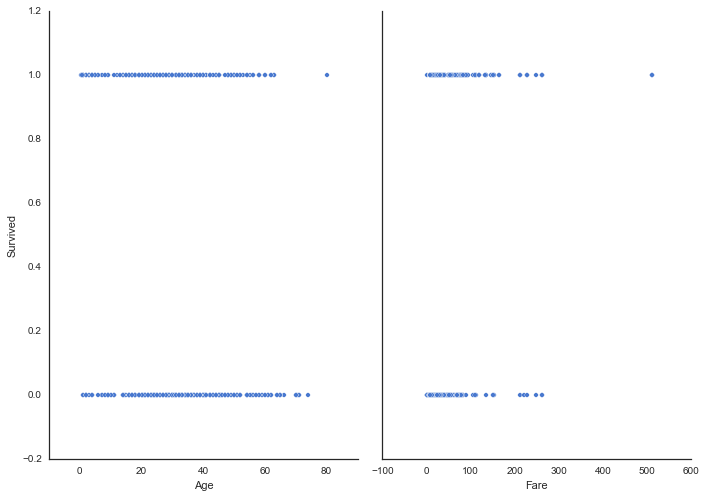

In [6]:
sns.pairplot(df_train, x_vars=['Age','Fare'], y_vars='Survived', size=7, aspect=0.7)

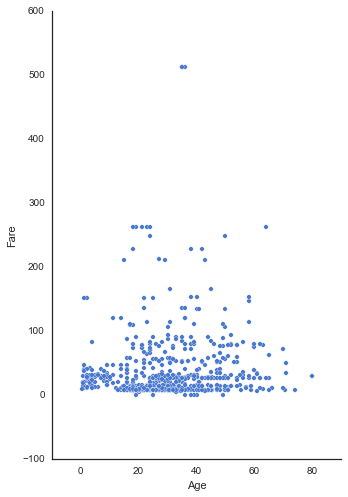

In [7]:
sns.pairplot(df_train, x_vars=['Age'], y_vars='Fare', size=7, aspect=0.7)

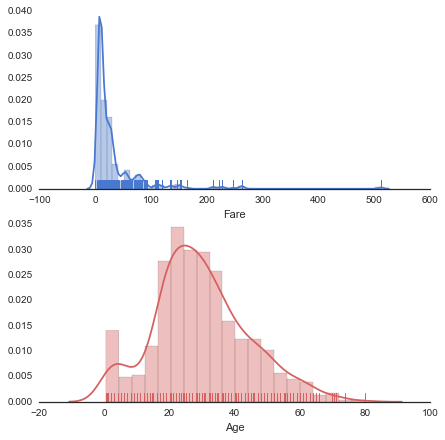

In [8]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, figsize=(7, 7), sharex=False)
sns.despine(left=True)

sns.distplot(df_train['Fare'].dropna(), hist=True, rug=True, color="b", ax=axes[0])
sns.distplot(df_train['Age'].dropna(), hist=True, rug=True, color="r", ax=axes[1])

#### Define features

In [9]:
X, y = df_train.ix[:,1:], df_train.Survived
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
   df_train.ix[:,1:], df_train.Survived, test_size=0.4, random_state=RND
)
kf_total = KFold(len(X), n_folds=10, shuffle=True, random_state=RND)
X.drop('Name', axis=1).head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,0,3,male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,X
1,1,1,female,38,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,1,3,female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,X
3,1,1,female,35,1,0,113803,53.1000,C123,S,Mrs,C
4,0,3,male,35,0,0,373450,8.0500,NaN,S,Mr,X


In [8]:
mapper = DataFrameMapper([
     ('Sex', preprocessing.LabelBinarizer()),
     ('Title', preprocessing.LabelBinarizer()),
     (['Age'], [preprocessing.Imputer(), preprocessing.StandardScaler()]),
     (['Fare'], [preprocessing.Imputer(),preprocessing.StandardScaler()]),
     (['SibSp'], preprocessing.Imputer(strategy='most_frequent')),
     (['Pclass'], preprocessing.Imputer(strategy='most_frequent')),
     (['Parch'], preprocessing.Imputer(strategy='most_frequent'))
    ])
# demo:
mapper.fit_transform(df_train.copy())[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.5924806 , -0.50244517,
        1.        ,  3.        ,  0.        ])

In [10]:
# alternative feature mapper inspired by eyebervil's feature selection
# things to consider:
# - convert titles to Mr. / Mrs.
# - define FamilySize = SibSp + Parch + 1
# - exploit cabin information
# - impute age via regression (how can this be structured in DataFrameMapper?)

# prepare a vectorized method that will standardize titles to one of: Mr, Mm, Ms
tmap = {}
tmap.update({k: 'Mr' for k in ("Mr", "Capt", "Master", "Col", "Don", "Jonkheer", "Major", "Rev", "Sir")})
tmap.update({k: 'Mm' for k in ("Mrs", "Dona", "Lady", "Mme", "Lady", "the Countess")})
tmap.update({k: 'Ms' for k in ("Mlle", "Ms", "Miss")})
lup = dict(male=tmap.copy(), female=tmap.copy())
lup['male']['Dr'] = 'Mr'
lup['female']['Dr'] = 'Mm'
lup_default = 'Mm'
def standardize_title(F):
    title, sex = F
    res = lup.get(sex, {}).get(title, lup_default)
    #print lup.get(sex, {})
    #print title, sex, res
    return res
def vectorized_standardize_title(F):
    return np.apply_along_axis(standardize_title, 1, F)
std_title = vectorized_standardize_title
def compute_family_size(F):
    return np.sum(F[:,0:2], axis=1)+1

mapper2 = DataFrameMapper([
     ('Sex', preprocessing.LabelBinarizer()),
     (['Age'], [preprocessing.Imputer(), preprocessing.StandardScaler()]),
     (['Fare'], [preprocessing.Imputer(),preprocessing.StandardScaler()]),
     (['Pclass'], preprocessing.Imputer(strategy='most_frequent')),
     # title group
     (['Title', 'Sex'], [preprocessing.FunctionTransformer(
                    std_title,
                    validate=False
                ),
                preprocessing.LabelBinarizer()]),
     # family size
     (['SibSp', 'Parch'], preprocessing.FunctionTransformer(compute_family_size)),
     # cabin information: check for presence
     #('Cabin', preprocessing.FunctionTransformer(lambda F: (pd.isnull(F)).astype(np.float64), validate=False)),
     # deck extracted from cabin
     ('Deck', preprocessing.LabelBinarizer())
    ])
# demo
mapper2.fit_transform(df_train.copy())[0:1]

array([[ 1.        , -0.5924806 , -0.50244517,  3.        ,  0.        ,
         1.        ,  0.        ,  2.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ]])

In [44]:
# mapper for tree-based regressions
mapper3 = DataFrameMapper([
     ('Sex', preprocessing.LabelEncoder()),
     ('Title', preprocessing.LabelEncoder()),
     (['Age'], [preprocessing.Imputer(), preprocessing.StandardScaler()]),
     (['Fare'], [preprocessing.Imputer(),preprocessing.StandardScaler()]),
     (['SibSp'], preprocessing.Imputer(strategy='most_frequent')),
     (['Pclass'], preprocessing.Imputer(strategy='most_frequent')),
     (['Parch'], preprocessing.Imputer(strategy='most_frequent')),
     ('Deck', preprocessing.LabelEncoder()),    # Titanic deck as extracted from the Cabin
     ('TicketNum', None)  # fully numeric ticket, or with a value?
    ])
# demo:
mapper3.fit_transform(df_train.copy())[0:2]

array([[  1.        ,  11.        ,  -0.5924806 ,  -0.50244517,
          1.        ,   3.        ,   0.        ,   8.        ,   0.        ],
       [  0.        ,  12.        ,   0.63878901,   0.78684529,
          1.        ,   1.        ,   0.        ,   2.        ,   0.        ]])

#### Build pipeline

In [11]:
model = dict()

##### Random Forest

In [12]:
cls = 'rf'
mod = model[cls] = dict()
mod['classifier'] = ensemble.RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=RND)
mod['params'] = dict(model__n_estimators=[100], model__random_state=[RND])
mod['pipe'] = pipeline.Pipeline([('featurize', mapper), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [77]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
scores = cross_val_score(mod['model'], df_train.copy(), df_train.Survived, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.81 (+/- 0.05)


##### SVM

In [16]:
cls='svm'
mod = model[cls] = dict()
mod['classifier'] = svm.SVC(random_state=RND)
mod['params'] = dict(model__kernel=['rbf', 'linear'], model__random_state=[RND])
mod['pipe'] = pipeline.Pipeline([('featurize', mapper), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [322]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
scores = cross_val_score(mod['model'], df_train.copy(), df_train.Survived, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("Accuracy: %0.3f" % (model['svm']['model'].score(df_train.copy(), df_train.Survived)))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.832 (+/- 0.031)
Accuracy: 0.835
[[490  59]
 [ 88 254]]


##### SVM 2 (add poly, use alt. features)

In [332]:
cls='svm2'
mod = model[cls] = dict()
mod['classifier'] = svm.SVC(random_state=RND)
mod['params'] = dict(model__kernel=['rbf', 'linear', 'poly'],
                     model__C=[0.1, 1.0, 10.0],
                     model__random_state=[RND])
mod['pipe'] = pipeline.Pipeline([('featurize', mapper2), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [333]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
scores = cross_val_score(mod['model'], df_train.copy(), df_train.Survived, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("Accuracy: %0.3f" % (model['svm']['model'].score(df_train.copy(), df_train.Survived)))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.826 (+/- 0.036)
Accuracy: 0.835
[[490  59]
 [ 85 257]]


##### SVM 3: like svm, but only linear and trying values of regularizer

In [17]:
cls='svm3'
mod = model[cls] = dict()
mod['classifier'] = svm.SVC(random_state=RND)
mod['params'] = dict(model__kernel=['linear'], model__random_state=[RND],
                     model__C=[0.1, 1.0, 10.0],)
mod['pipe'] = pipeline.Pipeline([('featurize', mapper), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [19]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
scores = cross_val_score(mod['model'], df_train.copy(), df_train.Survived, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.825 (+/- 0.031)
[[482  67]
 [ 87 255]]


##### Ada Boost

In [319]:
cls='adaboost'
mod = model[cls] = dict()
mod['classifier'] = ensemble.AdaBoostClassifier(random_state=RND)
mod['params'] = {'model__learning_rate': [0.3, 1.0, 1.3],
                 'model__base_estimator': [tree.DecisionTreeClassifier()]}
mod['pipe'] = pipeline.Pipeline([('featurize', mapper), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [320]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
scores = cross_val_score(mod['model'], df_train.copy(), df_train.Survived, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Accuracy: %0.3f" % (model['svm']['model'].score(df_train.copy(), df_train.Survived)))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)
# OK this is clearly overfitted...

Accuracy: 0.78 (+/- 0.05)
Accuracy: 0.835
[[547   2]
 [ 12 330]]


##### Logistic Regression

In [292]:
cls = 'logit'
mod = model[cls] = dict()
mod['classifier'] = linear_model.LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, random_state=RND)
mod['model'] = pipeline.Pipeline([('featurize', mapper), ('model', mod['classifier'])])

In [294]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
print("Accuracy: %0.3f (+/- %0.3f)" % (
    np.mean([max(sc) for sc in mod['classifier'].scores_[1]]),
    np.std([max(sc) for sc in mod['classifier'].scores_[1]])
))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.833 (+/- 0.027)
[[483  66]
 [ 89 253]]


##### Logistic Regression v2 (engineered features)

In [255]:
cls = 'logit2'
mod = model[cls] = dict()
mod['classifier'] = linear_model.LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, random_state=RND)
mod['model'] = pipeline.Pipeline([('featurize', mapper2), ('model', mod['classifier'])])

In [277]:
mod = model['logit2']
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
print("Accuracy: %0.3f (+/- %0.3f)" % (
    np.mean([max(sc) for sc in mod['classifier'].scores_[1]]),
    np.std([max(sc) for sc in mod['classifier'].scores_[1]])
))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.817 (+/- 0.021)
[[476  73]
 [ 94 248]]


##### Logistic with PCA

In [272]:
cls = 'logpca'
mod = model[cls] = dict()
mod['classifier'] = linear_model.LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, random_state=RND)
mod['model'] = pipeline.Pipeline([('featurize', mapper),
                                  ('pca', decomposition.PCA(n_components=10)),
                                  ('logit', mod['classifier'])])

In [278]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
print("Accuracy: %0.3f (+/- %0.3f)" % (
    np.mean([max(sc) for sc in mod['classifier'].scores_[1]]),
    np.std([max(sc) for sc in mod['classifier'].scores_[1]])
))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.831 (+/- 0.026)
[[483  66]
 [ 88 254]]


##### Logistic with polynomial features

In [268]:
cls = 'logpol'
mod = model[cls] = dict()
mod['classifier'] = linear_model.LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, random_state=RND)
mod['model'] = pipeline.Pipeline([('featurize', mapper), 
                                  ('polynomial', preprocessing.PolynomialFeatures(interaction_only=True,
                                                                                 degree=2)),
                                  ('model', mod['classifier'])])

In [271]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})
print("Accuracy: %0.2f (+/- %0.2f)" % (
    np.mean([max(sc) for sc in mod['classifier'].scores_[1]]),
    np.std([max(sc) for sc in mod['classifier'].scores_[1]])
))
print metrics.confusion_matrix(df_train.Survived, mod['model'].predict(df_train.copy()))
mod['pred'].to_csv('titanic/submissions/titanic_{}.csv'.format(cls), header=True, index=False)

Accuracy: 0.84 (+/- 0.03)
[[495  54]
 [ 89 253]]


##### xgboost

In [50]:
Y_train = df_train.Survived.as_matrix()
X_train = mapper3.fit_transform(df_train.copy())
dtrain = xgb.DMatrix(X_train, label=Y_train)

In [ ]:
cls = 'xgb1'
mod = model[cls] = dict()
mod['classifier'] = xgb.XGBClassifier()
mod['params'] = {'model__max_depth': [2, 4, 6],
                 'model__n_estimators': [50, 100, 200]}
mod['pipe'] = pipeline.Pipeline([('featurize', mapper3), ('model', mod['classifier'])])
mod['model'] = GridSearchCV(mod['pipe'], mod['params'], cv=10, n_jobs=-1)

In [ ]:
mod['model'].fit(df_train.copy(), df_train.Survived)
mod['pred'] = pd.DataFrame({'PassengerId': df_comp.PassengerId,
                            'Survived' : mod['model'].predict(df_comp.copy())})


In [ ]:
print(mod['pipe'].best_score_)
print(mod['pipe'].best_params_)


In [73]:
kf = cross_validation.KFold(Y_train.shape[0], n_folds=2, shuffle=True, random_state=RND)
for train_index, test_index in kf:
    xgb_model = xgb.XGBClassifier().fit(X_train[train_index],Y_train[train_index])
    predictions = xgb_model.predict(X_train[test_index])
    actuals = Y_train[test_index]
    print(metrics.confusion_matrix(actuals, predictions))

[[243  44]
 [ 31 128]]
[[242  20]
 [ 66 117]]


In [71]:
predictions

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1,

In [64]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic',
         'nthread': 4}
num_round = 2
print ('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'error'}, seed = 1)

running cross validation


,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.229213,0.044150,0.208989,0.011798
1,0.207865,0.034994,0.190169,0.009426


In [46]:
gbm = xgb.XGBClassifier(max_depth=4, n_estimators=1000, learning_rate=0.05).fit(Xs, Ys)
predictions = gbm.predict(mapper.fit_transform(df_comp.copy()))
metrics.accuracy_score(Ys, gbm.predict(Xs))

NameError: name 'Xs' is not defined

##### Old stuff

In [280]:
# TODO: this was trained on full sample!
if False:
    # https://github.com/justmarkham/DAT7/blob/master/notebooks/12_advanced_model_evaluation.ipynb
    # predict probability of survival
    y_pred_prob = pipe.predict_proba(df_train)[:, 1]
    # plot ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(df_train.Survived, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 0.3])
    plt.ylim([0.7, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')